In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import argparse
import os

Using TensorFlow backend.


## Mounting GDrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **IMPORTANT NOTE:**
#### If you take a look at Figure you can start to see our training and validation loss start to rapidly divide. When you see training loss falling quickly while validation loss stagnates or even increases, you know you are overfitting.

![alt text](https://pyimagesearch.com/wp-content/uploads/2019/06/unfrozen.png)

## What Is **MobileNetV2**?
#### MobileNets are small, low-latency, low-power models parameterised to meet the resource constraints of a variety of use cases. According to the research paper, MobileNetV2 improves the state-of-the-art performance of mobile models on multiple tasks and benchmarks as well as across a spectrum of different model sizes.
#### MobileNetV2 is optimised for mobile devices. The architecture delivers high accuracy results while keeping the parameters and mathematical operations as low as possible to bring deep neural networks to mobile devices.
#### The weights of the pre-trained snippets were learned by the Google team using **ImageNet**.
#### NOTE: **Weights in MobileNetV2:** 

One of the following:
*   None (random initialization)
*   'imagenet' (pre-training on ImageNet)
*   or the path to the weights file to be loaded. Default to imagenet.

---
#### To accomplish **FACE MASK DETECTOR**, we’ll be fine-tuning the MobileNet V2 architecture, a highly efficient architecture that can be applied to embedded devices with limited computational capacity (ex., Raspberry Pi, Google Coral, NVIDIA Jetson Nano, etc.).




---

## Parsing a few command line arguments that are required to launch our script from a terminal

In [3]:
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", required=True,
# 	help="path to input dataset")
# ap.add_argument("-p", "--plot", type=str, default="plot.png",
# 	help="path to output loss/accuracy plot")
# ap.add_argument("-m", "--model", type=str,
# 	default="mask_detector.model",
# 	help="path to output face mask detector model")
# args = vars(ap.parse_args())

## Defining Hyperparameters
#### We will be applying a learning rate decay schedule, which is why we’ve named the learning rate variable INIT_LR.

In [4]:
init_lr = 1e-4  # 0.0001
epochs = 20
bs = 32

## Loading and pre-processing our training data

In [8]:
imagePaths_mask = []
imagePaths_nomask = []

for filename in os.listdir("/content/drive/My Drive/Kaggle/Face Mask Detector/dataset/with_mask"):
  imagePaths_mask.append(filename)
for filename in os.listdir("/content/drive/My Drive/Kaggle/Face Mask Detector/dataset/without_mask"):
  imagePaths_nomask.append(filename)


**img_to_array()** - Keras provides the img_to_array() function for converting a loaded image in PIL format into a NumPy array for use with deep learning models.

**preprocess_input** - Model specific. The preprocess_input function is meant to adequate your image to the format the model requires

In [9]:
data = []
labels = []

for img in imagePaths_mask:

  label = 'with_mask'

  image = load_img("/content/drive/My Drive/Kaggle/Face Mask Detector/dataset/with_mask/"+img, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)

for img in imagePaths_nomask:

  label = 'without_mask'

  image = load_img("/content/drive/My Drive/Kaggle/Face Mask Detector/dataset/without_mask/"+img, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

## Encoding our labels - one hot encoding

**to_categorical** - Converts a class vector (integers) to binary class matrix.

TEXT REPRESENTATION -> NUMBER REPRESENTATION -> ONE HOT ENCODING|

In [11]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("Text categories in number form: \n",labels)
labels = to_categorical(labels)
print("One Hot Encoding: \n",labels)

Text categories in number form: 
 [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
One Hot Encoding: 
 [[[0. 1.]
  [1. 0.]]

 [[0. 1.]
  [1. 0.]]

 [[0. 1.]
  [1. 0.]]

 ...

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


## Splitting Training and Testing Data

**stratify** - This stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.

For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

**random_state = 42** - For randomly selecting input data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


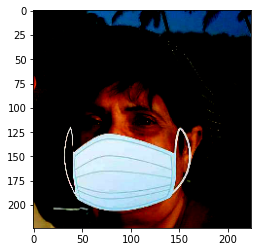

In [22]:
plt.imshow(data[0])

In [24]:
(train_x,test_x,train_y,test_y) = train_test_split(data, labels, test_size = 0.20, stratify = labels, random_state = 42)

ValueError: ignored